In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import optimize
from scipy.special import expit

In [2]:
data = pd \
    .read_csv('data/logistic_regression_2.txt', names=['x1', 'x2', 'y']) \
    .sample(frac=1)
data.reset_index(inplace=True, drop=True)

for column in data.columns:
    if column == 'y':
        continue
    data[column] = (data[column] - data[column].mean()) / data[column].std()

print(data.describe())
data.head()

                 x1            x2           y
count  1.180000e+02  1.180000e+02  118.000000
mean   6.303809e-17  4.327988e-17    0.491525
std    1.000000e+00  1.000000e+00    0.502060
min   -1.781621e+00 -1.833294e+00    0.000000
25%   -8.595503e-01 -8.417365e-01    0.000000
50%   -1.230541e-01  5.840087e-02    0.000000
75%    8.540982e-01  8.917119e-01    1.000000
max    2.045934e+00  1.781262e+00    1.000000


,x1,x2,y
0,1.558714,-1.355096,0
1,-0.958130,-0.876898,1
2,-0.934935,-1.144126,0
3,0.004528,1.415620,0
4,1.245558,0.881163,0


In [3]:
def draw_train_set(data):
    ax = data[data['y'] == 0].plot.scatter(x='x1', y='x2', c='red')
    data[data['y'] == 1].plot.scatter(x='x1', y='x2', c='blue', ax=ax)

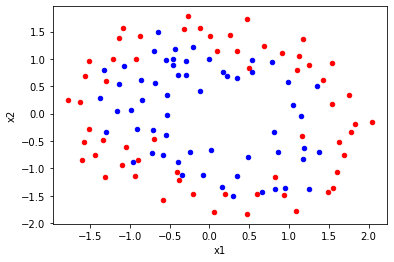

In [4]:
draw_train_set(data)

In [40]:
def extract(data, start, end):
    m = data.shape[0]
    view = data[start:(end - 1)]
    
    dropped_view = view
    if 'y' in data.columns:
        dropped_view = dropped_view.drop('y', axis=1)
    if 'y^' in data.columns:
        dropped_view = dropped_view.drop('y^', axis=1)
    X = dropped_view.to_numpy()
    y = None
    if 'y' in data.columns:
        y = view['y'].to_numpy().reshape(view.shape[0], 1)
    return X, y

def expand(data, p, min_p=0):
    p = p + 1
    m = data.shape[0]
    n = data.shape[1]
    result = data.copy()
    
    pv = [0] * n
    while True:
        r = 1
        sumof = 0
        for i in range(0, n):
            if data.columns[i] in ['y', 'y^']:
                continue
            pv[i] = pv[i] + r
            r = pv[i] // p
            pv[i] = pv[i] % p
            if pv[i] < min_p:
                sumof = 0
                break
            sumof = sumof + pv[i]
        if r > 0:
            break
        if sumof < 2:
            continue
        toadd = None
        name = ''
        for i in range(0, n):
            if pv[i] < 1 or data.columns[i] in ['y', 'y^']:
                continue
            name = name + data.columns[i]
            if pv[i] > 1:
                name = name + '^' + str(pv[i])
            temp = data[data.columns[i]].pow(pv[i])
            if toadd is None:
                toadd = temp
            else:
                toadd = toadd.add(temp)
        
        result[name] = toadd
        
    result.insert(0, 'x0', [1] * m)
        
    return result
    

def cost_fn(theta, X, y, lamb):
    # Note: np.multiply performs element-wise multiplication instead of matrix multiplication
    # Note: np.matmul performs matrix multiplication
    # Note: expit is the sigmoid function
    m = X.shape[0]
    n = X.shape[1]
    Theta = theta.reshape(n, 1)
    
    h = expit(np.matmul(X, Theta))
    
    result = (np.matmul(y.T, np.log(h)) + np.matmul(1 - y.T, np.log(1 - h))) / (-m)
    result = result[0,0]
    result = result + (lamb / (2 * m)) * (np.sum(np.multiply(Theta, Theta)) - math.pow(Theta[0,0], 2))
    
    return result

def gradient_fn(theta, X, y, lamb):
    m = X.shape[0]
    n = X.shape[1]
    Theta = theta.reshape(n, 1)
    
    h = expit(np.matmul(X, Theta))
    result = (np.matmul(X.T, (h - y)) / m)
    
    lamb_vector = np.ones((n, 1))
    lamb_vector[0, 0] = 0
    
    result = result + (lamb / m) * np.multiply(lamb_vector, Theta)
    
    return result.reshape(n)

def solve(X, y, lamb):
    n = X.shape[1]
    result = optimize.minimize(
        lambda theta: cost_fn(theta, X, y, lamb),
        jac=lambda theta: gradient_fn(theta, X, y, lamb),
        x0=np.array([0] * n),
        method='BFGS')
    return result.x.reshape(n, 1)

def predict(X, theta):
    return (expit(np.matmul(X, theta)) >= 0.5).reshape(X.shape[0]).astype(int)

def accuracy(X, y, theta):
    return np.sum((y.reshape(X.shape[0]) == predict(X, theta)).astype(int)) / X.shape[0]

def f1score(X, y, theta):
    yh = predict(X, theta)
    y = y.reshape(X.shape[0])
    tp = np.sum(np.logical_and(yh == 1, y == 1).astype(int))
    fp = np.sum(np.logical_and(yh == 1, y == 0).astype(int))
    fn = np.sum(np.logical_and(yh == 0, y == 1).astype(int))
    return tp / (tp + ((fp + fn) / 2))

def check_gradient_inner(n, cost_fn, gradient_fn):
    EPSILON = 1e-5
    theta = np.random.rand(n)
    result = np.zeros((n,))
    for i in range(0, n):
        theta[i] = theta[i] + EPSILON
        cost_plus = cost_fn(theta)
        theta[i] = theta[i] - 2 * EPSILON
        cost_minus = cost_fn(theta)
        theta[i] = theta[i] + EPSILON
        estimated_grad = (cost_plus - cost_minus) / (2 * EPSILON)
        real_grad = gradient_fn(theta)
        result[i] = (estimated_grad - real_grad[i]) / real_grad[i]
    return result

def check_gradient(data, lamb):
    m = data.shape[0]
    expanded = expand(data, 0)
    X, y = extract(expanded, 0, m + 1)
    n = X.shape[1]
    return check_gradient_inner(
        n,
        lambda theta: cost_fn(theta, X, y, lamb),
        lambda theta: gradient_fn(theta, X, y, lamb),
    )
    
def select_model(data, max_p):
    m = data.shape[0]

    df = pd.DataFrame(index=range(0, max_p + 1), columns=['power',
                                                          'cost', 'accuracy', 'f1',
                                                          'cost(minp=p)', 'accuracy(minp=p)', 'f1(minp=p)'])
    for p in range(0, max_p + 1):
        expanded = expand(data, p)
        Xtrain, ytrain = extract(expanded, 0, math.ceil(m*0.8))
        Xcv, ycv = extract(expanded, math.ceil(m*0.8), m + 1)
        theta = solve(Xtrain, ytrain, 0)
        cost = cost_fn(theta, Xcv, ycv, 0)
        acc = accuracy(Xcv, ycv, theta)
        f1 = f1score(Xcv, ycv, theta)
        
        expanded = expand(data, p, p)
        Xtrain, ytrain = extract(expanded, 0, math.ceil(m*0.8))
        Xcv, ycv = extract(expanded, math.ceil(m*0.8), m + 1)
        theta = solve(Xtrain, ytrain, 0)
        cost_minp_eq_p = cost_fn(theta, Xcv, ycv, 0)
        acc_minp_eq_p = accuracy(Xcv, ycv, theta)
        f1_minp_eq_p = f1score(Xcv, ycv, theta)        
        
        df.loc[p] = [p, cost, acc, f1, cost_minp_eq_p, acc_minp_eq_p, f1_minp_eq_p]
    
    ax = df.plot.line(x='power', y='cost')
    df.plot.line(x='power', y='cost(minp=p)', ax=ax)
    
    ax = df.plot.line(x='power', y='accuracy')
    df.plot.line(x='power', y='accuracy(minp=p)', ax=ax)
    
    ax = df.plot.line(x='power', y='f1')
    df.plot.line(x='power', y='f1(minp=p)', ax=ax)
    
    df.sort_values(by=['cost'], inplace=True)
    df.reset_index(inplace=True, drop=True)
    df.sort_values(by=['accuracy'], ascending=False, inplace=True)
    
    return df
    
        

In [41]:
check_gradient(data, 0)

array([-7.44542662e-11,  2.99522035e-11,  2.88250561e-10])

In [42]:
check_gradient(data, 1000)

array([ 1.83290358e-11, -3.46934135e-12, -1.19617558e-09])

<ipython-input-5-1dace2752c78>:71: RuntimeWarning: divide by zero encountered in log
  result = (np.matmul(y.T, np.log(h)) + np.matmul(1 - y.T, np.log(1 - h))) / (-m)
<ipython-input-5-1dace2752c78>:71: RuntimeWarning: invalid value encountered in matmul
  result = (np.matmul(y.T, np.log(h)) + np.matmul(1 - y.T, np.log(1 - h))) / (-m)
<ipython-input-5-1dace2752c78>:71: RuntimeWarning: divide by zero encountered in log
  result = (np.matmul(y.T, np.log(h)) + np.matmul(1 - y.T, np.log(1 - h))) / (-m)
<ipython-input-5-1dace2752c78>:71: RuntimeWarning: divide by zero encountered in log
  result = (np.matmul(y.T, np.log(h)) + np.matmul(1 - y.T, np.log(1 - h))) / (-m)
<ipython-input-5-1dace2752c78>:71: RuntimeWarning: invalid value encountered in matmul
  result = (np.matmul(y.T, np.log(h)) + np.matmul(1 - y.T, np.log(1 - h))) / (-m)
<ipython-input-5-1dace2752c78>:71: RuntimeWarning: divide by zero encountered in log
  result = (np.matmul(y.T, np.log(h)) + np.matmul(1 - y.T, np.log(1 - h))) /

,power,cost,accuracy,f1,cost(minp=p),accuracy(minp=p),f1(minp=p)
6,6,0.491657,0.73913,0.75,0.68895,0.565217,0.583333
5,5,0.49757,0.73913,0.727273,0.68895,0.565217,0.583333
2,2,0.508866,0.782609,0.761905,0.68895,0.565217,0.583333
3,3,0.510873,0.73913,0.727273,0.68895,0.565217,0.583333
7,7,0.52183,0.73913,0.75,0.68895,0.565217,0.583333
4,4,0.550783,0.782609,0.782609,0.68895,0.565217,0.583333
8,8,0.587068,0.782609,0.782609,0.68895,0.565217,0.583333
10,10,0.611051,0.695652,0.72,0.68895,0.565217,0.583333
9,9,0.623139,0.73913,0.727273,0.68895,0.565217,0.583333
0,0,0.68895,0.565217,0.583333,0.68895,0.565217,0.583333


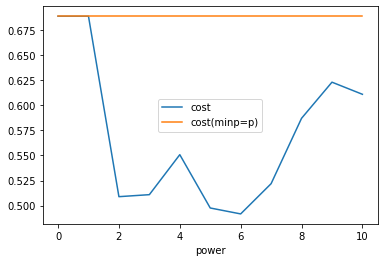

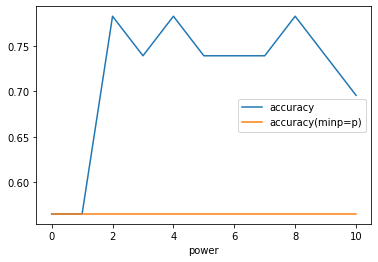

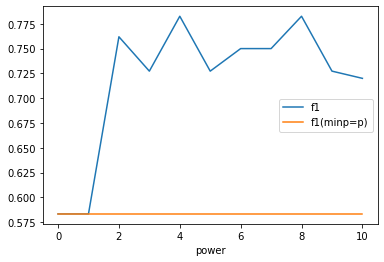

In [6]:
select_model(data, 10)

In [7]:
P = 4
expanded = expand(data, P)
X, y = extract(expanded, 0, data.shape[0] + 1)
Xtrain, ytrain = extract(expanded, 0, math.ceil(data.shape[0] * 0.8))
Xcv, ycv = extract(expanded, math.ceil(data.shape[0] * 0.8), data.shape[0] + 1)
theta = solve(X, y, 0)
print(expanded.columns)
del expanded
theta

Index(['x0', 'x1', 'x2', 'y', 'x1^2', 'x1^3', 'x1^4', 'x1x2', 'x1^2x2',
       'x1^3x2', 'x1^4x2', 'x2^2', 'x1x2^2', 'x1^2x2^2', 'x1^3x2^2',
       'x1^4x2^2', 'x2^3', 'x1x2^3', 'x1^2x2^3', 'x1^3x2^3', 'x1^4x2^3',
       'x2^4', 'x1x2^4', 'x1^2x2^4', 'x1^3x2^4', 'x1^4x2^4'],
      dtype='object')


array([[ 3.46430925e+00],
       [ 1.60520785e-01],
       [-1.20230981e-02],
       [ 8.90232993e-02],
       [ 1.86105032e-01],
       [ 5.66598798e-03],
       [ 1.48497687e-01],
       [ 7.70002012e-02],
       [ 1.74081934e-01],
       [-6.35711016e-03],
       [-5.15950995e-01],
       [-3.55430209e-01],
       [-4.26927696e-01],
       [-3.29845963e-01],
       [-5.10285007e-01],
       [-1.75508264e-01],
       [-1.49874783e-02],
       [-8.64849644e-02],
       [ 1.05967682e-02],
       [-1.69842276e-01],
       [-8.73856173e-02],
       [ 7.31351681e-02],
       [ 1.63768200e-03],
       [ 9.87194146e-02],
       [-8.17196293e-02]])

In [8]:
def plot_model(data, P, theta, step, sensitivity=0.2):
    if P < 2:
        xmin = data['x1'].min()
        xmax = data['x1'].max()
        count = math.ceil((xmax - xmin) / step)
        Xplot = pd.DataFrame(index=range(0, count), columns=['x'])
        Xplot['x1'] = np.arange(xmin, xmax, step)
        if P == 1:
            Xplot['x2'] = -(theta[0,0] + theta[1,0] * Xplot['x1']) / (theta[2,0] + theta[3,0] * Xplot['x1'])
        elif P == 0:
            Xplot['x2'] = -(theta[0,0] + theta[1,0] * Xplot['x1']) / (theta[2,0])
        ax = Xplot.plot.line(x='x1', y='x2',c='g')
    else:
        x1min = data['x1'].min()
        x1max = data['x1'].max()
        x2min = data['x2'].min()
        x2max = data['x2'].max()
        x1count = math.ceil((x1max - x1min) / step)
        x2count = math.ceil((x2max - x2min) / step)
        Xplot = pd.DataFrame(index=range(0, x1count * x2count), columns=['x1', 'x2'])
        for i in range(0, x1count):
            x1 = x1min + step * i
            for j in range(0, x2count):
                x2 = x2min + step * j
                Xplot.loc[i * x1count + j] = [x1, x2]
        Xplot = expand(Xplot, P)
        X, _ = extract(Xplot, 0, Xplot.shape[0] + 1)
        Xplot['y^'] = (np.abs((np.matmul(X, theta)) - 0) < sensitivity).reshape(X.shape[0]).astype(int)
        ax = Xplot[Xplot['y^'] == 1].plot.scatter(x='x1', y='x2', c='green')
        
    ax = data[data['y'] == 0].plot.scatter(x='x1', y='x2', c='red', ax=ax)
    data[data['y'] == 1].plot.scatter(x='x1', y='x2', c='blue', ax=ax)

<ipython-input-8-614e7deca4dc>:28: RuntimeWarning: invalid value encountered in less
  Xplot['y^'] = (np.abs((np.matmul(X, theta)) - 0) < 0.2).reshape(X.shape[0]).astype(int)


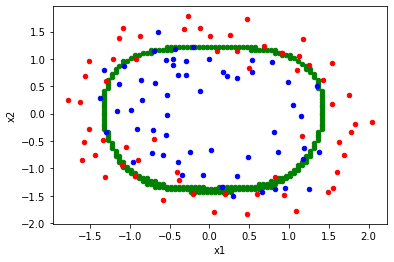

In [9]:
plot_model(data, P, theta, 0.05, sensitivity=0.2)

In [10]:
def select_lambda(Xtrain, ytrain, Xcv, ycv, begin, end, step):
    m = data.shape[0]
    
    count = math.ceil((end - begin) / step)
    df = pd.DataFrame(index=range(0, count), columns=['lambda', 'cost', 'accuracy', 'f1'])
    
    for i in range(0, count):
        lamb = begin + i * step
        theta = solve(Xtrain, ytrain, lamb)
        cost = cost_fn(theta, Xcv, ycv, 0)
        acc = accuracy(Xcv, ycv, theta)
        f1 = f1score(Xcv, ycv, theta)
        df.loc[i] = [lamb, cost, acc, f1]
        
    df.plot.line(x='lambda', y='cost')
    df.plot.line(x='lambda', y='accuracy')
    df.plot.line(x='lambda', y='f1')
    df.sort_values(by=['cost'], inplace=True)
    print(df)

    lambda      cost  accuracy        f1
6        7  0.509709  0.695652  0.695652
5        6  0.509716  0.695652  0.695652
7        8  0.509743  0.695652  0.695652
8        9    0.5098  0.695652  0.695652
4        5  0.509801  0.695652  0.695652
..     ...       ...       ...       ...
994    995  0.590847  0.652174  0.666667
995    996  0.590897  0.652174  0.666667
996    997  0.590947  0.652174  0.666667
997    998  0.590997  0.652174  0.666667
998    999  0.591046  0.652174  0.666667

[999 rows x 4 columns]


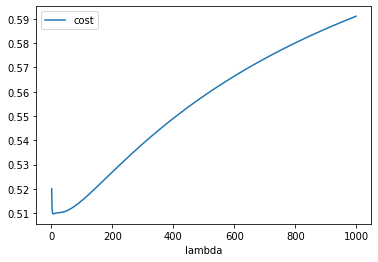

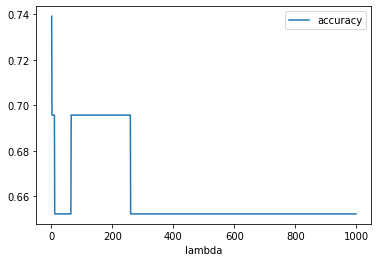

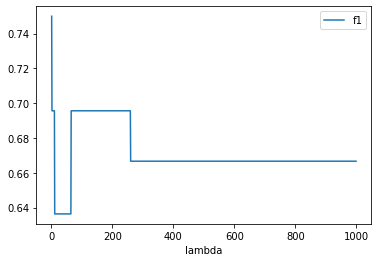

In [11]:
select_lambda(Xtrain, ytrain, Xcv, ycv, 0, 1000, 1)

In [12]:
lamb = 20
theta = solve(X, y, lamb)
data['y^'] = (np.matmul(X, theta) >= 0.5).astype(int).reshape(X.shape[0])
theta

array([[ 2.37328044],
       [ 0.03841793],
       [ 0.01604991],
       [-0.02062305],
       [ 0.06690435],
       [-0.07303153],
       [ 0.05446785],
       [-0.00457314],
       [ 0.08295426],
       [-0.05698162],
       [-0.09806489],
       [-0.05964696],
       [-0.11868794],
       [-0.03116054],
       [-0.17109643],
       [-0.05435872],
       [-0.01594078],
       [-0.07498177],
       [ 0.01254563],
       [-0.12739025],
       [-0.09872643],
       [-0.0603085 ],
       [-0.11934948],
       [-0.03182208],
       [-0.17175796]])

In [13]:
def draw_learning_curve(data, P, lamb, start=None, end=None):
    df = [] # m, cv, train
    expanded = expand(data, P)
    
    start = start or 0
    end = end or data.shape[0]
    
    for m in range(start, end + 1):  
        Xtrain, ytrain = extract(expanded, 0, math.ceil(m*0.8))
        Xcv, ycv = extract(expanded, math.ceil(m*0.8), m + 1)
        if ycv.shape[0] < 1:
            continue
        
        theta = solve(Xtrain, ytrain, lamb)
        cost_train = cost_fn(theta, Xtrain, ytrain, 0)
        cost_cv = cost_fn(theta, Xcv, ycv, 0)
        
        df.append([m, cost_cv, cost_train])
            
    df = pd.DataFrame(df, columns=['m', 'cv', 'train'])
    ax = df.plot.line(x='m', y='cv')
    df.plot.line(x='m', y='train', ax=ax)


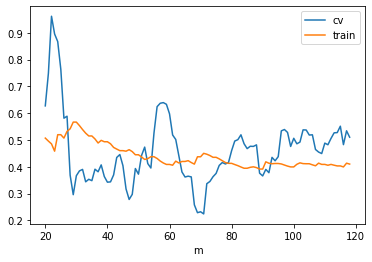

In [14]:
draw_learning_curve(data, P, lamb, start=20)